<a href="https://colab.research.google.com/github/fjtm/Data/blob/master/dogsVScats_francisco_javier_tebar_martinez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Comentarios profesor:

Utilizar accuracy. 

Parecido a Random Forest.

Primer bloque tratamiento de los datos. Cargar y tratar las imágenes (resize...), cada imagen tiene un tamaño diferente. 
Escalar las imágnes, montar el tensor, normalizar a (-0.5, 0.5). No pintar la versión normalizada. 

Random suffle para mezclar perros y gatos. 

Modelo básico. 

Conseguir almenos un 60% de accuracy

Para mejorar el modelo (opcional).

Earlystopping (recomendable).

Gridsearch (sin gpu no hacerlo). 

Tecnicas de aumentación de datos (recomendable).


Al final un informe, diciendo lo que hemos probado y que da...


Empezar con imágnes pequeñas y luego ir subiendo. 

# Lab assignment: dogs VS cats

<table><tr>
    <td><img src="https://raw.githubusercontent.com/fjtm/Data/master/img/doge.jpg"   height="400" width="400"></td>
    <td><img src="https://raw.githubusercontent.com/fjtm/Data/master/img/cat.jpg" height="400" width="400"></td>
</tr></table>

In this assignment we will face an image classification problem, trying to tell apart images of dogs and images of cats. The final battle begins! And to do so we will use a Deep Learning approach.

## Guidelines

Throughout this notebook you will find empty cells that you will need to fill with your own code. Follow the instructions in the notebook and pay special attention to the following symbols.

<img src="https://raw.githubusercontent.com/fjtm/Data/master/img/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
You will need to solve a question by writing your own code or answer in the cell immediately below or in a different file, as instructed.</font>

***

<img src="https://raw.githubusercontent.com/fjtm/Data/master/img/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
This is a hint or useful observation that can help you solve this assignment. You should pay attention to these hints to better understand the assignment.
</font>

***

<img src="https://raw.githubusercontent.com/fjtm/Data/master/img/pro.png" height="80" width="80" style="float: right;"/>

***
<font color=#259b4c>
This is an advanced exercise that can help you gain a deeper knowledge into the topic. Good luck!</font>

***

To avoid missing packages and compatibility issues you should run this notebook under one of the [recommended Deep Learning environment files](https://github.com/albarji/teaching-environments/tree/master/deeplearning).

The following code will embed any plots into the notebook instead of generating a new window:

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

Lastly, if you need any help on the usage of a Python function you can place the writing cursor over its name and press Caps+Shift to produce a pop-out with related documentation. This will only work inside code cells. 

Let's go!

In [3]:
import glob
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.callbacks import EarlyStopping
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core import Flatten
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import GridSearchCV
import time
from keras.wrappers.scikit_learn import KerasClassifier

from keras.layers import Input
from keras.models import Model
from keras.applications import vgg16

Using TensorFlow backend.


**Creamos una carpeta en el directorio actual con los datos de la práctica almacenados en github (Este proceso es un poco lento pero permite ejecutar el notebook tanto en local, como en google colab). Si bien, si no se trabaja con google colab y  se disponen de los datos, recomiendo crear una carpeta de nombre Data en el directorio actual con los datos de train y test para mayor velocidad, en vez de clonar el repositorio de github.** 

In [4]:
!git clone --recursive https://github.com/fjtm/Data.git

Cloning into 'Data'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 25035 (delta 6), reused 20 (delta 4), pack-reused 25011
Receiving objects: 100% (25035/25035), 612.60 MiB | 46.91 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Checking out files: 100% (25010/25010), done.


## Data processing

The images to use in this assignment are available [here](https://drive.google.com/open?id=105jGDrjEgxx2W2gYhFF8Mbf1J9qJeDPm). Download the data package and extract it into a folder in your computer.

Data is structured under two folders, *train* and *test*. You are only allowed to use the *test* data to measure the performance of your model **after** you have finished training. Both *train* and *test* folders contain one subfolder per class (*cats* and *dogs*).

The recommended way to load an image from disk is to use the *imread* function from the *scikit-image* library. For example:

In [0]:
image = imread("Data/img/sample.jpg")

This returns the image as 3-dimensional numpy matrix, containing the value of intensity of every pixel in each row, column and color channel.

In [6]:
image.shape

(499, 367, 3)

We can visualize the loaded image using

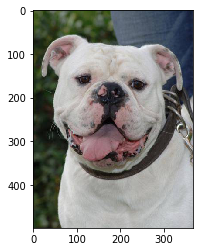

In [7]:
plt.imshow(image)

The dataset includes 20000 training images and 5000 test images, each image at a different resolution. Loading all this data at once requires too much memory, so we will need to **resize** each image to a smaller, common size as we load them from disk. We can do so by again making use of a *scikit-image* function. For example:

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


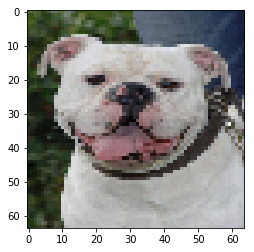

In [8]:
size = 64
smallimage = resize(image, (64, 64, 3), mode="reflect")  # 64 x 64 pixels, 3 color channels
plt.imshow(smallimage)


<img src="https://raw.githubusercontent.com/fjtm/Data/master/img/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
    
Perform the following tasks to prepare the data:
- Build a numpy array *X_train* containing one entry for each training image in the data. Each entry must contain the 3-dimensional matrix of pixels corresponding to an image. Make sure to scale down each image to a common size
- Normalize *X_train* so that pixels follow a distribution lying in the range [-0.5,0.5]
- Build a corresponding array *Y_train* with the class of each training image (0 for cats and 1 for dogs).
- Randomly shuffle the data. Make sure you shuffle both *X_train* and *Y_train* using the same permutation, so you don't lose track of the class of each training pattern.

- Repeat the whole procedure again to generate *X_test* and *Y_test* matrices for the test data.
</font>

***

<img src="https://raw.githubusercontent.com/fjtm/Data/master/img/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
- Take advantage of the *glob* package to generate the filename lists for the indoor and outdoor subfolders.
- Since you need to repeat the procedure both for training and test data, it would be useful to implement a function that performs all the data loading and transforming steps.
</font>

***

Creamos una función que tomando una imagen la reescala, creando un cubo de datos con el tamaño de la imagen (filas y columnas) y el número de canales. (tamaño de las filas, tamaño de las columnas, canales (RGB)). Además desplazamos la distribución de pixeles originales entre $[0,1]$ a $[-0.5,0.5]$.

In [0]:
def preprocesing(image, size = 64, mode = "reflect"):
    return(np.array(resize(imread(image), (size, size, 3), mode=mode, anti_aliasing=True)-0.5))

In [10]:
X_train = []
Y_train = []
X_test = []
Y_test = []

print("Loading cats train")
for image in glob.glob('Data/train/cats/*.jpg'):
    X_train.append(preprocesing(image))
    Y_train.append(0)
print("Loading dogs train")
for image in glob.glob('Data/train/dogs/*.jpg'):
    X_train.append(preprocesing(image))
    Y_train.append(1)
print("Loading cats test")
for image in glob.glob('Data/test/cats/*.jpg'):
    X_test.append(preprocesing(image))
    Y_test.append(0)
print("Loading dogs test")
for image in glob.glob('Data/test/dogs/*.jpg'):
    X_test.append(preprocesing(image))
    Y_test.append(1)
print("Complete")

Loading cats train
Loading dogs train
Loading cats test
Loading dogs test
Complete


If everything has been properly loaded both X_train and Y_train lists should have equal length, and the same should happen for the pair X_test and Y_test.

In [11]:
print("X_train size", len(X_train))
print("Y_train size", len(Y_train))
print("X_test size", len(X_test))
print("Y_test size", len(Y_test))

X_train size 20000
Y_train size 20000
X_test size 5000
Y_test size 5000


Cambiamos el formato de X_train y X_test a un ndarray con (número de imagenes, 64, 64, 3) y mezclamos las imágenes. En este trabajo no se trabajará con imagenes con mayor resulición ya que sino podemos tener problemas de memoria.

In [0]:
np.random.seed(12)
index_train = np.arange(20000)
np.random.shuffle(index_train)
index_test = np.arange(5000)
np.random.shuffle(index_test)

In [0]:
X_train = np.asarray(X_train)[index_train]
X_test = np.asarray(X_test)[index_test]
Y_train = np.asarray(Y_train)[index_train]
Y_test = np.asarray(Y_test)[index_test]

Modificamos las etiquetas creando las categorías.  

In [0]:
from keras.utils import np_utils

In [0]:
Y_train = np_utils.to_categorical(Y_train, 2)
Y_test = np_utils.to_categorical(Y_test, 2)

## Basic deep model

<img src="https://raw.githubusercontent.com/fjtm/Data/master/img/question.png" height="80" width="80" style="float: right;"/>

***
<font color=#ad3e26>
Create a deep network that achieves at least a 60% of accuracy in the test set. Make use of the layers you seem fit for problem. You cannot use the test data for fitting the network, but you can use it to check the final performance of different network architectures, and select the architecture performing best.</font>

***

En esta primera parte mostraré algunas de las CNN que he probado y que van aumentando en complejidad hasta la arquitectura elegida:

<ol>
1. CNN 1:
    <br>
    <ul>
        <li> 32 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes valid)
        <li> Capa de MaxPooling (2,2)
        <li> Capa Flatten
        <li> Capa Densa con 2 neuronas (Con función de activación sigmoide)
    </ul>  
2. CNN 2:
    <ul>
        <li> 32 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes valid)
        <li> Capa de MaxPooling (2,2)
        <li> Capa Flatten
        <li> Capa densa con 64 neuronas (Con función de activación Relu) y dropout (0.5)
        <li> Capa densa con 2 neuronas (Con función de activación sigmoide)
    </ul>
3. CNN 3:
    <ul>
        <li> 32 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes valid)
        <li> Capa de MaxPooling (2,2)
        <li> 64 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes valid)
        <li> Capa de MaxPooling (2,2)
        <li> Capa Flatten
        <li> Capa densa con 256 neuronas (Con función de activación Relu) y dropout (0.5)
        <li> Capa densa con 2 neuronas (Con función de activación sigmoide)
    </ul>
4. CNN 4: 
    <ul>
        <li> 32 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes same)
        <li> Capa de MaxPooling (2,2)
        <li> 64 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes same)
        <li> Capa de MaxPooling (2,2)
        <li> 128 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes same)
        <li> Capa de MaxPooling (2,2)
        <li> 256 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes same)
        <li> Capa de MaxPooling (2,2)
        <li> Capa Flatten
        <li> Capa densa con 512 neuronas (Con función de activación Relu) y dropout (0.5)
        <li> Capa densa con 2 neuronas (Con función de activación sigmoide)
    </ul>
5. CNN 5:
    <ul>
        <li> 32 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes same)
        <li> 32 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes same)
        <li> Capa de MaxPooling (2,2)
        <li> 64 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes same)
        <li> 64 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes same)
        <li> Capa de MaxPooling (2,2)
        <li> 128 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes same)
        <li> 128 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes same)
        <li> Capa de MaxPooling (2,2)
        <li> 256 capas convolucionales con kernels (3,3) (Con función de activación Relu y tratamiento de bordes same)
        <li> Capa de MaxPooling (2,2)
        <li> Capa Flatten
        <li> Capa densa con 512 neuronas (Con función de activación Relu) y dropout (0.5)
        <li> Capa densa con 2 neuronas (Con función de activación sigmoide)
    </ul>
  </ol>

Antes de utilizar estos modelos es necario tomar algunas consideraciones.
<ol>
<li> <b>Función de pérdida</b> </li>
    <ul>
De entre la gran variedad de funciones de pérdida disponibles en keras, he elegido <b>binary crossentropy</b> puesto que tenemos un problema de clasificiación con solamente dos clases. Esta se puede expresar como:

$$H_p(q) = -\frac{1}{N_0 + N_1}[\sum_{i=1}^{N_0}log(p(y_i)) + \sum_{i=1}^{N_1}log(p(y_i))]$$
con $N_0$ el número de gatos y $N_1$ el número de perros. 
</ul>
<li> <b>Solver de optimización</b> </li>
<ul> 
En este caso utilizaremos el solver de optimización <b>adam</b> ya que funciona bien para problemas con muchos datos y/o parámetros.
</ul>
<li> <b>Número de epochs</b> </li>
<ul>    
Designa el número de veces que la red neuronal utilizará todos los datos de entrenamiento para actualizar los pesos. En este caso, de manera un poco manual considero que unas <b>10</b> o <b>20</b> epochs son suficientes. 
</ul>
<li> <b>Tamaño del batch</b> </li>
<ul>   
Designa el tamaño del subconjunto de datos tomados de train para actualizar los parámetros. En este caso utilizaremos <b>128</b>, lo que equivale sobre nuestro dataset de 20000 imágenes de entrenamiento a unas 150 imágnes. 
</ul>
<li> <b>Métrica</b> </li>
<ul>
Puesto que tenemos un problema con las clases perfectamente balanceadas podemos utilizar una métrica simple como es <b>accuracy</b>. 
</ol>

## CNN 1

Creamos la arquitectura del modelo y lo compilamos con el solver anterior y la función de perdida anterior. 

In [16]:
img_rows = 64 # Tamaño de la imagen de entrada (Filas)
img_cols = 64 # Tamaño de la imagen de entrada (Columnas)
kernel_size = 3 # Tamaño del kernel de convolución
pool_size = 2 # Tamaño de la región de pulido

model = Sequential()

model.add(Convolution2D(32, (kernel_size, kernel_size), padding='valid', input_shape=(img_rows, img_cols, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Flatten())

model.add(Dense(2,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


Entrenamos la red con el tamaño del batch y el número de epochs

In [17]:
model.fit(
    X_train, 
    Y_train, 
    batch_size=128, 
    epochs=20, 
    verbose=2 
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
 - 7s - loss: 0.6151 - acc: 0.6618
Epoch 2/20
 - 2s - loss: 0.5562 - acc: 0.7201
Epoch 3/20
 - 2s - loss: 0.5118 - acc: 0.7564
Epoch 4/20
 - 2s - loss: 0.4892 - acc: 0.7704
Epoch 5/20
 - 2s - loss: 0.4676 - acc: 0.7835
Epoch 6/20
 - 2s - loss: 0.4547 - acc: 0.7944
Epoch 7/20
 - 2s - loss: 0.4379 - acc: 0.7987
Epoch 8/20
 - 2s - loss: 0.4241 - acc: 0.8098
Epoch 9/20
 - 2s - loss: 0.4142 - acc: 0.8137
Epoch 10/20
 - 2s - loss: 0.4077 - acc: 0.8182
Epoch 11/20
 - 2s - loss: 0.3963 - acc: 0.8243
Epoch 12/20
 - 2s - loss: 0.3878 - acc: 0.8304
Epoch 13/20
 - 2s - loss: 0.3784 - acc: 0.8366
Epoch 14/20
 - 2s - loss: 0.3700 - acc: 0.8401
Epoch 15/20
 - 2s - loss: 0.3633 - acc: 0.8422
Epoch 16/20
 - 2s - loss: 0.3558 - acc: 0.8504
Epoch 17/20
 - 2s - loss: 0.3493 - acc: 0.8519
Epoch 18/20
 - 2s - loss: 0.3425 - acc: 0.8557
Epoch 19/20
 - 2s - loss: 0.3367 - acc: 0.8594
Epoch 20/20
 - 2s - loss: 0.3283 - acc: 0.8632


Vemos la actuación del modelo sobre los datos de test.

In [18]:
score = model.evaluate(X_test, Y_test)
print("Test loss %.4f" % score[0])
print("Test accuracy %.4f" % score[1])

5000/5000 [==============================] - 1s 130us/step
Test loss 0.4996
Test accuracy 0.7723


Con este modelo bastante simple conseguimos un accuracy mayor del 70%

## CNN 2

Estudiemos los resultados con la segunda arquitectura considerada.

In [19]:
img_rows = 64 # Tamaño de la imagen de entrada (Filas)
img_cols = 64 # Tamaño de la imagen de entrada (Columnas)
kernel_size = 3 # Tamaño del kernel de convolución
pool_size = 2 # Tamaño de la región de pulido

model = Sequential()

model.add(Convolution2D(32, (kernel_size, kernel_size), padding='valid', input_shape=(img_rows, img_cols, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Flatten())

model.add(Dense(16))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(2,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
model.fit(
    X_train, 
    Y_train, 
    batch_size=128, 
    epochs=20, 
    verbose=2 
)

Epoch 1/20
 - 3s - loss: 0.6705 - acc: 0.5587
Epoch 2/20
 - 2s - loss: 0.6368 - acc: 0.5948
Epoch 3/20
 - 2s - loss: 0.6212 - acc: 0.6026
Epoch 4/20
 - 2s - loss: 0.6088 - acc: 0.6157
Epoch 5/20
 - 2s - loss: 0.5998 - acc: 0.6181
Epoch 6/20
 - 2s - loss: 0.5885 - acc: 0.6253
Epoch 7/20
 - 2s - loss: 0.5804 - acc: 0.6279
Epoch 8/20
 - 2s - loss: 0.5698 - acc: 0.6334
Epoch 9/20
 - 2s - loss: 0.5621 - acc: 0.6370
Epoch 10/20
 - 2s - loss: 0.5586 - acc: 0.6408
Epoch 11/20
 - 2s - loss: 0.5544 - acc: 0.6421
Epoch 12/20
 - 2s - loss: 0.5486 - acc: 0.6485
Epoch 13/20
 - 2s - loss: 0.5370 - acc: 0.6555
Epoch 14/20
 - 2s - loss: 0.5364 - acc: 0.6583
Epoch 15/20
 - 2s - loss: 0.5348 - acc: 0.6538
Epoch 16/20
 - 2s - loss: 0.5268 - acc: 0.6572
Epoch 17/20
 - 2s - loss: 0.5206 - acc: 0.6603
Epoch 18/20
 - 2s - loss: 0.5138 - acc: 0.6654
Epoch 19/20
 - 2s - loss: 0.5117 - acc: 0.6805
Epoch 20/20
 - 2s - loss: 0.4951 - acc: 0.7077


In [21]:
score = model.evaluate(X_test, Y_test)
print("Test loss %.4f" % score[0])
print("Test accuracy %.4f" % score[1])

5000/5000 [==============================] - 1s 123us/step
Test loss 0.4811
Test accuracy 0.7623


Tenemos un resultado similar al del modelo anterior.

## CNN 3

In [0]:
img_rows = 64 # Tamaño de la imagen de entrada (Filas)
img_cols = 64 # Tamaño de la imagen de entrada (Columnas)
kernel_size = 3 # Tamaño del kernel de convolución
pool_size = 2 # Tamaño de la región de pulido

model = Sequential()

model.add(Convolution2D(32, (kernel_size, kernel_size), padding='valid', input_shape=(img_rows, img_cols, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(64, (kernel_size, kernel_size), padding='valid'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Flatten())

model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(2,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
model.fit(
    X_train, 
    Y_train, 
    batch_size=128, 
    epochs=20, 
    verbose=2 
)

Epoch 1/20
 - 4s - loss: 0.6067 - acc: 0.6613
Epoch 2/20
 - 3s - loss: 0.4975 - acc: 0.7601
Epoch 3/20
 - 3s - loss: 0.4498 - acc: 0.7912
Epoch 4/20
 - 3s - loss: 0.4067 - acc: 0.8145
Epoch 5/20
 - 3s - loss: 0.3711 - acc: 0.8356
Epoch 6/20
 - 3s - loss: 0.3304 - acc: 0.8574
Epoch 7/20
 - 3s - loss: 0.2859 - acc: 0.8800
Epoch 8/20
 - 3s - loss: 0.2412 - acc: 0.9015
Epoch 9/20
 - 3s - loss: 0.2076 - acc: 0.9153
Epoch 10/20
 - 3s - loss: 0.1611 - acc: 0.9383
Epoch 11/20
 - 3s - loss: 0.1296 - acc: 0.9514
Epoch 12/20
 - 3s - loss: 0.1010 - acc: 0.9649
Epoch 13/20
 - 3s - loss: 0.0836 - acc: 0.9709
Epoch 14/20
 - 3s - loss: 0.0740 - acc: 0.9752
Epoch 15/20
 - 3s - loss: 0.0573 - acc: 0.9821
Epoch 16/20
 - 3s - loss: 0.0463 - acc: 0.9861
Epoch 17/20
 - 3s - loss: 0.0400 - acc: 0.9879
Epoch 18/20
 - 3s - loss: 0.0365 - acc: 0.9883
Epoch 19/20
 - 3s - loss: 0.0325 - acc: 0.9899
Epoch 20/20
 - 3s - loss: 0.0274 - acc: 0.9916


In [24]:
score = model.evaluate(X_test, Y_test)
print("Test loss %.4f" % score[0])
print("Test accuracy %.4f" % score[1])

5000/5000 [==============================] - 1s 135us/step
Test loss 0.7564
Test accuracy 0.8187


En este caso conseguimos superar el 80% de accuracy. Sin embargo, si vemos el accuracy durante el entrenamiento, el modelo está realizando un claro overfit. 

## CNN 4

Notese que en este caso utilizamos el enfoque *same* ya que al utilizar tantas capas de MaxPooling necesitamos preservar que el tamaño de la imagen tras pasar las capas de convolución sea razonable.  

In [0]:
img_rows = 64 # Tamaño de la imagen de entrada (Filas)
img_cols = 64 # Tamaño de la imagen de entrada (Columnas)
kernel_size = 3 # Tamaño del kernel de convolución
pool_size = 2 # Tamaño de la región de pulido

model = Sequential()

model.add(Convolution2D(32, (kernel_size, kernel_size), padding='same', input_shape=(img_rows, img_cols, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(64, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(128, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(256, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Flatten())

model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(2,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
model.fit(
    X_train, 
    Y_train, 
    batch_size=128, 
    epochs=10, 
    verbose=2 
)

Epoch 1/10
 - 5s - loss: 0.6247 - acc: 0.6390
Epoch 2/10
 - 4s - loss: 0.4998 - acc: 0.7584
Epoch 3/10
 - 4s - loss: 0.4118 - acc: 0.8126
Epoch 4/10
 - 4s - loss: 0.3439 - acc: 0.8482
Epoch 5/10
 - 4s - loss: 0.2965 - acc: 0.8716
Epoch 6/10
 - 4s - loss: 0.2437 - acc: 0.8964
Epoch 7/10
 - 4s - loss: 0.1950 - acc: 0.9222
Epoch 8/10
 - 4s - loss: 0.1371 - acc: 0.9470
Epoch 9/10
 - 4s - loss: 0.1037 - acc: 0.9605
Epoch 10/10
 - 4s - loss: 0.0696 - acc: 0.9739


In [27]:
score = model.evaluate(X_test, Y_test)
print("Test loss %.4f" % score[0])
print("Test accuracy %.4f" % score[1])

5000/5000 [==============================] - 1s 174us/step
Test loss 0.4469
Test accuracy 0.8635


Mejoramos el resultado anterior pero claramente la red sigue haciendo overfitting. 

## CNN 5

In [0]:
img_rows = 64 # Tamaño de la imagen de entrada (Filas)
img_cols = 64 # Tamaño de la imagen de entrada (Columnas)
kernel_size = 3 # Tamaño del kernel de convolución
pool_size = 2 # Tamaño de la región de pulido

model = Sequential()

model.add(Convolution2D(32, (kernel_size, kernel_size), padding='same', input_shape=(img_rows, img_cols, 3)))
model.add(Activation("relu"))
model.add(Convolution2D(32, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(64, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(Convolution2D(64, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(128, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(Convolution2D(128, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(256, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Flatten())

model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(2,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
model.fit(
    X_train, 
    Y_train, 
    batch_size=128, 
    epochs=10, 
    verbose=2 
)

Epoch 1/10
 - 9s - loss: 0.6503 - acc: 0.6002
Epoch 2/10
 - 8s - loss: 0.5501 - acc: 0.7236
Epoch 3/10
 - 8s - loss: 0.4539 - acc: 0.7909
Epoch 4/10
 - 8s - loss: 0.3613 - acc: 0.8401
Epoch 5/10
 - 8s - loss: 0.3051 - acc: 0.8702
Epoch 6/10
 - 8s - loss: 0.2568 - acc: 0.8925
Epoch 7/10
 - 8s - loss: 0.2188 - acc: 0.9097
Epoch 8/10
 - 8s - loss: 0.1786 - acc: 0.9267
Epoch 9/10
 - 8s - loss: 0.1516 - acc: 0.9408
Epoch 10/10
 - 8s - loss: 0.1300 - acc: 0.9476


In [30]:
score = model.evaluate(X_test, Y_test)
print("Test loss %.4f" % score[0])
print("Test accuracy %.4f" % score[1])

5000/5000 [==============================] - 1s 236us/step
Test loss 0.2928
Test accuracy 0.8926


Obtenemos el mejor resultado hasta al momento llegando casi al 90% de acierto. En este caso aunque la red sigue haciendo overfitting este no es tan pronunciado como las CNN anteriores. Así, quedemonos con esta arquitectura. 

<img src="https://raw.githubusercontent.com/fjtm/Data/master/img/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
    
If you are unable to attain the required 60% of accuracy, or your accuracy is too close to 100%, review the following checklist:
- Have you mixed training and test data?
- Have the values of the pixels been normalized?
- Have you compiled the model with a loss function appropriate for **binary** classification?
- Have you used ReLU units in the hidden layers? Have you used sigmoid or softmax layers in the output layer?

***

## Improving the network

<img src="https://raw.githubusercontent.com/fjtm/Data/master/img/pro.png" height="80" width="80" style="float: right;"/>

***

<font color=#259b4c>
    
You can further improve your results by applying one or more of the following strategies:
<li>
Keep apart a portion of the training data as a **validation set**. Then use an <a href="https://keras.io/callbacks/#earlystopping">**EarlyStopping strategy**</a> to monitor the loss of these validation data, and stop when training when after a number of iterations such loss has not decreased.
<li>
Make use of **metamodelling techniques** to select the best architecture parameters for the networks. You can use scikit-learn methods GridSearchCV or RandomSearchCV. You can do those by using the <a href="https://keras.io/scikit-learn-api/">KerasClassifier</a> wrapper. Even better, you can mix KerasClassifier with an advanced search method such as [BayesSearch](https://scikit-optimize.github.io/#skopt.BayesSearchCV), included in the [scikit-optimize](https://scikit-optimize.github.io/) library.
<li>
Use **image augmentation techniques** to artifically create new training images. To do so, you can make use of <a href="https://keras.io/preprocessing/image/">ImageDataGenerator</a> in Keras.
<li>
Make use of a pre-trained large network, building your network on top of it. You can find some examples in the [Keras Applications](https://keras.io/applications/) page.

If you correctly use these techniques you should be able to improve your model. With some effort it is possible to up to a 90% test accuracy. Try to do your best!</font>

***

IMPORTANTE

Ejecutar esta parte del código sin google colab requiere una gran cantidad de tiempo de entrenamiento. De esta manera, he guardado el modelo creado en el entorno de google colab en github. 

Una vez seleccionada la arquitectura de la red neuronal intentaremos mejorar el rendimiento de esta mediante las técnicas sugeridas. En concreto nos basaremos principalmente en dos de ellas:

<ol>
<li> <b>EarlyStopping strategy</b> </li>
    <ul>
Permite detener el entrenamiento si la función de pérdida en el conjunto de validación no decrece durante un cierto número de epochs, en concreto utilizaremos 5 epochs como margen. Puesto que 5 iteraciones pueden llevar a un mayor ovefit sin una mejora en el modelo, utilizaremos el parámetro <b>restore_best_weights</b> el cual devuelve los mejores pesos de las últimas 5 epochs en caso de que la función de perdida no decrezca durante estas iteraciones. Esta es una estrategia muy buena para controlar el overfit en las CNN.
</ul>

<li> <b>ImageDataGenerator</b> </li>
<ul> 
Esta técnica permite modificar las imagenes de train ligeramente mediante rotaciones, translaciones, zoom... Con esto se logra aumentar cosiderablemente el número de imágenes con las que entrenas el modelo sin necesidad de disponer de imágenes nuevas. 
</ul>
<br>

Para poder llevar a cabo las técnicas anteriormente comentadas es necesario separar un porcentaje de imágenes que utilizaremos para ir validando el modelo. Así, utilizaremos 2000 imágenes para validar y las 18000 restantes junto con la tecnica de aumentación de imágenes para entrenar la red. 

In [0]:
X_validate = X_train[0:2000]
Y_validate = Y_train[0:2000]
X_not_validate = X_train[2000:len(X_train)]
Y_not_validate = Y_train[2000:len(X_train)]

Creamos el generador de imágenes.

In [0]:
datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='reflect')

datagen.fit(X_not_validate)

Definimos la arquitectura.

In [0]:
img_rows = 64 # Tamaño de la imagen de entrada (Filas)
img_cols = 64 # Tamaño de la imagen de entrada (Columnas)
kernel_size = 3 # Tamaño del kernel de convolución
pool_size = 2 # Tamaño de la región de pulido

model = Sequential()

model.add(Convolution2D(32, (kernel_size, kernel_size), padding='same', input_shape=(img_rows, img_cols, 3)))
model.add(Activation("relu"))
model.add(Convolution2D(32, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(64, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(Convolution2D(64, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(128, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(Convolution2D(128, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(256, (kernel_size, kernel_size), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Flatten())

model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(2,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

En este caso aumentamos el número de epochs a 100, ya que EarlyStopping detendrá el algoritmo cuando la función de perdida del set de validación no decrezca.

In [0]:
# Ejecutar solamente en google colab o en un entorno con GPU

model_final = model.fit_generator(datagen.flow(X_not_validate, Y_not_validate, batch_size=128),
                    steps_per_epoch=len(X_not_validate)/128, epochs=100, verbose=0,
                    validation_data = (X_validate, Y_validate),
                    callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10, restore_best_weights=True)] 
)

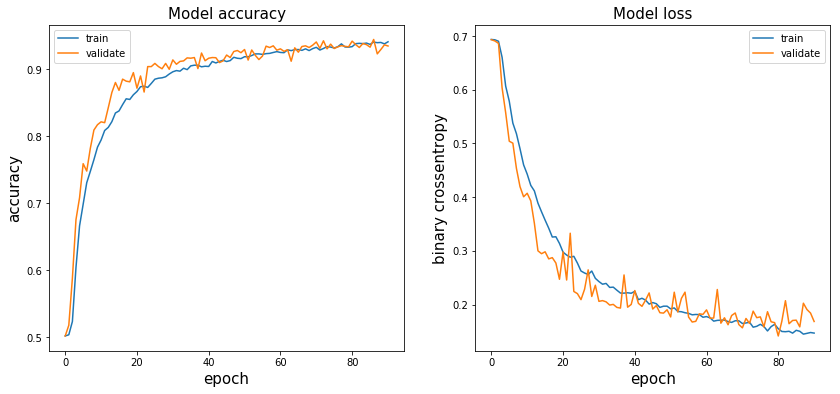

In [91]:
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.plot(model_final.history['acc'])
plt.plot(model_final.history['val_acc'])
plt.title('Model accuracy', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.legend(['train', 'validate'], loc='best')

plt.subplot(122)
plt.plot(model_final.history['loss'])
plt.plot(model_final.history['val_loss'])
plt.title('Model loss', fontsize=15)
plt.ylabel('binary crossentropy', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.legend(['train', 'validate'], loc='best')
plt.show()

In [92]:
score = model.evaluate(X_test, Y_test)
print("Test loss %.4f" % score[0])
print("Test accuracy %.4f" % score[1])

5000/5000 [==============================] - 1s 237us/step
Test loss 0.1464
Test accuracy 0.9388


De esta manera utilizando estas técnicas, conseguimos mejorar el accuracy sobre el test entorno al $5$-$6\%$ con un modelo con la misma arquitectura. 

De las técnias sugeridas he intentado utilizar GridSearchCV para optimizar el número de neuronas por capa o el porcentaje de dropout de las capas densas..., sin embargo si se intenta trabajar con todas las imagenes nos quedamos sin memoria rapidamente. De esta manera utilizo una porción reducida de imagenes (12000) para intentar determinar el porcentaje de dropout óptimo. Realizo este proceso más para ilustrar como combinar GridSearchCV de sklearn con Keras, que para sacar un verdadero beneficio para construir el modelo.

In [0]:
def create_model(dropout_rate=0.0):
  
  img_rows = 64
  img_cols = 64
  kernel_size = 3 
  pool_size = 2

  model_drop = Sequential()

  model_drop.add(Convolution2D(32, (kernel_size, kernel_size),
                          padding='same', input_shape=(img_rows, img_cols, 3)))
  model_drop.add(Activation("relu"))
  model_drop.add(Convolution2D(32, (kernel_size, kernel_size),
                         padding='same'))
  model_drop.add(Activation("relu"))
  model_drop.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

  model_drop.add(Convolution2D(64, (kernel_size, kernel_size),
                         padding='same'))
  model_drop.add(Activation("relu"))
  model_drop.add(Convolution2D(64, (kernel_size, kernel_size),
                         padding='same'))
  model_drop.add(Activation("relu"))
  model_drop.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

  model_drop.add(Convolution2D(128, (kernel_size, kernel_size),
                         padding='same'))
  model_drop.add(Activation("relu"))
  model_drop.add(Convolution2D(128, (kernel_size, kernel_size),
                         padding='same'))
  model_drop.add(Activation("relu"))
  model_drop.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

  model_drop.add(Convolution2D(256, (kernel_size, kernel_size),
                         padding='same'))
  model_drop.add(Activation("relu"))
  model_drop.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

  model_drop.add(Flatten())
  model_drop.add(Dense(512))
  model_drop.add(Activation("relu"))
  model.add(Dropout(dropout_rate))
  model_drop.add(Dense(2))
  model_drop.add(Activation("sigmoid"))
  
  model_drop.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model_drop

In [56]:
model_drop = KerasClassifier(build_fn=create_model, epochs=20, batch_size=128, verbose=0)
dropout_rate = [0.1,0.5,0.9]
param_grid = dict(dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model_drop, param_grid=param_grid, cv = 3)
t0 = time.time()
grid_result = grid.fit(X_train[0:3000], Y_train[0:3000])
print("Tiempo de búsqueda:", np.round((time.time()-t0)/60,1), "min")

Tiempo de búsqueda: 3.3 min


In [64]:
print("Best accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for mean, stdev, param in zip(grid_result.cv_results_['mean_test_score'],
                              grid_result.cv_results_['std_test_score'],
                              grid_result.cv_results_['params']):
    print("Accuracy %f std (%f) con: %r" % (mean, stdev, param))

Best accuracy: 0.722667 using {'dropout_rate': 0.5}
Accuracy 0.703500 std (0.017354) con: {'dropout_rate': 0.1}
Accuracy 0.722667 std (0.007576) con: {'dropout_rate': 0.5}
Accuracy 0.646000 std (0.052888) con: {'dropout_rate': 0.9}


En este caso para  las tres posibilidades estudiadas, el modelo obtiene los mejores resultados para un dropout de 0.5 como veniamos utilizando hasta ahora.  

Llegados a este punto ya tenemos un buen modelo que consigue un accuracy de más del 90%. Probemos ahora a modificar un modelo ya existente para ver si logramos mejorar el resultado.

En este caso utilizaremos el modelo VGG16 presentado originalmente en el paper <a href = "https://arxiv.org/abs/1409.1556">Very Deep Convolutional Networks for Large-Scale Image Recognition</a> por K. Simonyan and A. Zisserman de la universidad de Oxford. Este presenta la siguiente arquitectura:



<td style="height:200px;">
    <table>
         <tr>
              <td><img src="https://raw.githubusercontent.com/fjtm/Data/master/img/vgg16.png"   height="200" width="800"></td>   
         </tr>
         <tr>
              <td><img src="https://raw.githubusercontent.com/fjtm/Data/master/img/vgg16-1-e1542731207177.png" height="400" width="800"></td>
         </tr>
    </table>
</td>

En concreto el modelo que podemos importar de keras solamente tiene las capas convolucionales,  y por tanto es necesario crear manualmente las capas densas. Además, este modelo toma imágenes de 226x226 y puesto que por impedimentos de memoria estamos trabajando con imágenes de 64x64, será necesario introducir otra capa inicial para redefinir el tamaño de entrada. 

Así nuestro modelo seguirá la estructura: 

<li> Capa de entrada (64,64,3)
<li> Estructura convolucional del modelo vvg16
<li> Flatten
<li> Capa densa de 512 neuronas con activación relu y dropout del 50%.
<li> Capa densa de 2 neuronas con activación sigmoide

In [84]:
model_vgg16 = vgg16.VGG16(include_top=False, weights='imagenet')

input = Input(shape=(64,64,3))
model_vgg16_mod = model_vgg16(input)

x = Flatten(name='flatten')(model_vgg16_mod)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='sigmoid')(x)
 
vgg16_tune_model = Model(input=input, output=x)

vgg16_tune_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()


In [85]:
# Ejecutar solamente en google colab o en un entorno con GPU

vgg16_tune_model_results = vgg16_tune_model.fit_generator(datagen.flow(X_not_validate, Y_not_validate, batch_size=128),
                    steps_per_epoch=len(X_not_validate)/128, epochs=100, verbose=2,
                    validation_data = (X_validate, Y_validate),
                    callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10, restore_best_weights=True)] 
)

Epoch 1/100
 - 28s - loss: 0.7099 - acc: 0.5448 - val_loss: 0.6399 - val_acc: 0.6510
Epoch 2/100
 - 24s - loss: 0.6095 - acc: 0.6685 - val_loss: 0.5295 - val_acc: 0.7120
Epoch 3/100
 - 24s - loss: 0.5194 - acc: 0.7481 - val_loss: 0.4048 - val_acc: 0.8223
Epoch 4/100
 - 23s - loss: 0.4520 - acc: 0.7923 - val_loss: 0.3935 - val_acc: 0.8368
Epoch 5/100
 - 23s - loss: 0.4172 - acc: 0.8162 - val_loss: 0.3404 - val_acc: 0.8463
Epoch 6/100
 - 23s - loss: 0.3748 - acc: 0.8349 - val_loss: 0.2972 - val_acc: 0.8723
Epoch 7/100
 - 24s - loss: 0.3459 - acc: 0.8491 - val_loss: 0.2779 - val_acc: 0.8902
Epoch 8/100
 - 23s - loss: 0.3289 - acc: 0.8607 - val_loss: 0.2723 - val_acc: 0.8848
Epoch 9/100
 - 23s - loss: 0.3323 - acc: 0.8551 - val_loss: 0.2438 - val_acc: 0.8983
Epoch 10/100
 - 24s - loss: 0.3215 - acc: 0.8594 - val_loss: 0.2519 - val_acc: 0.8953
Epoch 11/100
 - 23s - loss: 0.2815 - acc: 0.8803 - val_loss: 0.2172 - val_acc: 0.9092
Epoch 12/100
 - 23s - loss: 0.2679 - acc: 0.8871 - val_loss: 0.

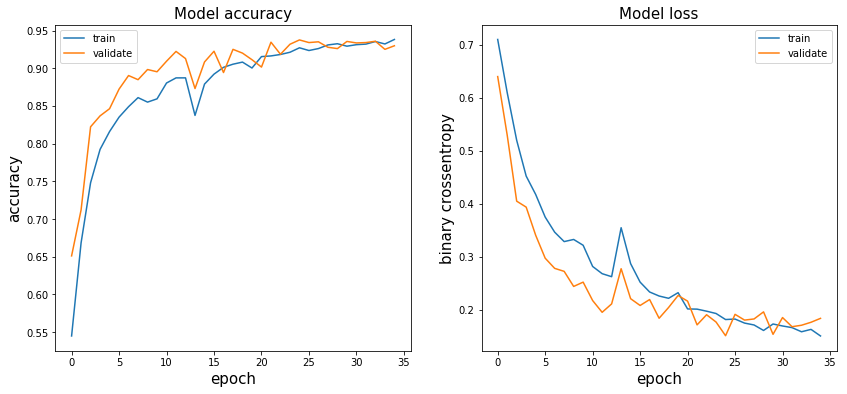

In [86]:
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.plot(vgg16_tune_model_results.history['acc'])
plt.plot(vgg16_tune_model_results.history['val_acc'])
plt.title('Model accuracy', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.legend(['train', 'validate'], loc='best')

plt.subplot(122)
plt.plot(vgg16_tune_model_results.history['loss'])
plt.plot(vgg16_tune_model_results.history['val_loss'])
plt.title('Model loss', fontsize=15)
plt.ylabel('binary crossentropy', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.legend(['train', 'validate'], loc='best')
plt.show()

In [88]:
score = vgg16_tune_model.evaluate(X_test, Y_test)
print("Test loss %.4f" % score[0])
print("Test accuracy %.4f" % score[1])

5000/5000 [==============================] - 3s 602us/step
Test loss 0.1390
Test accuracy 0.9373


## Analyzing the results

<img src="https://raw.githubusercontent.com/fjtm/Data/master/img/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
Find and show some test images for which your model fails. Can you give an explanation for this behavior?</font>

***

In [0]:
####### INSERT YOUR CODE HERE

<img src="https://raw.githubusercontent.com/fjtm/Data/master/img/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
Write a small report summarizing the network choices you have tried, what worked and what didn't. What have you learned from this experience?</font>

***

Valid, sin earlystopping ni nada.

Con capa densa de 16 neuronas


Convolucional 3 (32, 3, 3) (64, 3, 3) (128, 3, 3) un 86.1% batch_size=128


Convolucional 1 (32, 3, 3) un 77% de accuracy. Sin capa densa de 16 neuronas batch_size=128

Convolucional 2 (32, 3, 3) (32, 3, 3) un 79-80%. Sin capa densa de 16 neuronas batch_size=128

Convolucional 2 (32, 3, 3) (64, 3, 3) un 82.42%. Sin capa densa de 16 neuronas batch_size=128

Convolucional 3 (32, 3, 3) (64, 3, 3) (128, 3, 3) un 87.8% batch_size=128

Convolucional 3 (32, 3, 3) (64, 3, 3) (128, 3, 3) con una red densa 128 neuronas (90% drop out)  88.52% batch_size=128

Convolucional 3 (32, 3, 3) (64, 3, 3) (128, 3, 3) con una red densa 256 neuronas (95% drop out)  87.44% batch_size=128

Same. No da buenos resultados de momento.

